In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

DATASET = 'rigid-dataset'

def get_residue_distance_path(dataset):
    return f'../../../data/features/residue-distances/{dataset}'
def get_fluctuation_path(dataset):
    return f'../../../data/features/fluctuation/{dataset}/fluctuation'
def get_indices_path(dataset):
    return f'../../../data/features/fluctuation/{dataset}/indices'

### Histogram of avg. distances

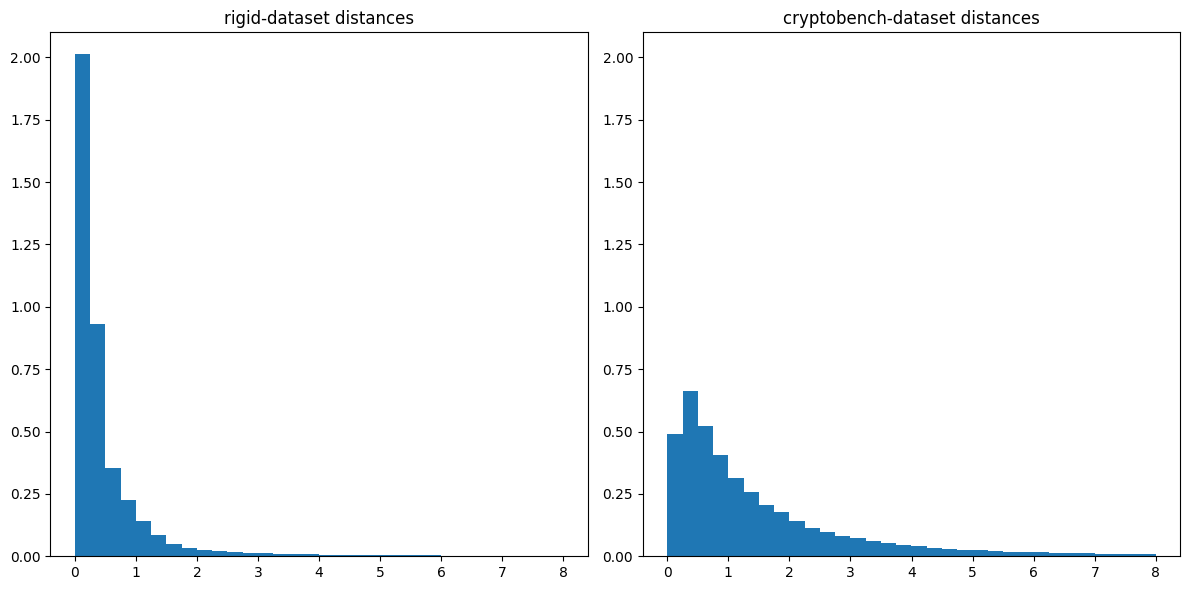

In [2]:
def plot_residue_distances(dataset):
    residue_distances_path= get_residue_distance_path(dataset)

    def get_residue_distances(path):
        residue_distances = {}
        for file in os.listdir(path):
            residue_distances[file.split('.')[0]] = np.load(f"{path}/{file}")
        return residue_distances

    distances = get_residue_distances(residue_distances_path)

    concatenated_distances = np.array([])
    for key, value in distances.items():
        concatenated_distances = np.concatenate((concatenated_distances, value))

    trimmed_distances = concatenated_distances[(concatenated_distances < 8) & (concatenated_distances > 0)]
    return trimmed_distances

datasets = ['rigid-dataset', 'cryptobench-dataset']
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for i, dataset in enumerate(datasets):
    trimmed_distances = plot_residue_distances(dataset)
    axs[i].hist(trimmed_distances, bins=32, density=True)
    axs[i].set_title(f'{dataset} distances')
    axs[i].set_ylim(0, 2.1)

plt.tight_layout()
plt.show()

### Create 4 bins
Let's create four intervals: [0, 0.5], [0.5, 1.5], [1.5, 2.5], [2.5, inf]. For each interval, show how fluctuation is behaving.

In [ ]:
import numpy as np

def bin_fluctuations_by_distance(dataset, bins, labels, reverse_modes=False):
    binned_fluctuation = {label: [] for label in labels}
    for file in os.listdir(get_residue_distance_path(dataset)):
        fluctuations = np.load(f"{get_fluctuation_path(dataset)}/{file}")
        distances = np.load(f"{get_residue_distance_path(dataset)}/{file}")

        if reverse_modes:
            fluctuations = np.flip(fluctuations, axis=0) # axis=0 means we are taking the modes (axis=1 would mean taking the residues)

        # fluctuations[0] means the first mode, fluctuation[0][1] means the first mode for the second residue, etc.

        # let's transpose it:
        fluctuations = np.transpose(fluctuations)
        # now fluctuations[0] means the fluctuations of the first residue, fluctuations[0][1] means the fluctuations of the second mode for the first residue, etc.

        # loop over the residues
        for residue_idx, residue_fluctuation in enumerate(fluctuations):
            # check which bin the distance of the residue falls into
            for i, bin in enumerate(bins):
                if bins[i] < distances[residue_idx] <= bins[i+1]:
                    binned_fluctuation[labels[i]].append(residue_fluctuation)

    # now we have the binned fluctuations dictionary
    # each key is a distance bin
    # each value is a list of residues
    # now we want to have a similar dictionary, but the values is a list of modes, so we need to transpose the entries

    binned_fluctuation_transposed = {label: [] for label in labels}

    # for each distance bin
    for label, residues in binned_fluctuation.items():
        # for each residue
        for residue in residues:
            for mode_index, mode_value in enumerate(residue):
                # if the mode is not yet in the bin, add it
                if len(binned_fluctuation_transposed[label]) <= mode_index:
                    binned_fluctuation_transposed[label].append([])
                # add the residue to the correct mode
                binned_fluctuation_transposed[label][mode_index].append(mode_value)
    del binned_fluctuation

    for label, fluctuations in binned_fluctuation_transposed.items():
        for i, fluctuation in enumerate(fluctuations):
            binned_fluctuation_transposed[label][i] = np.array(fluctuation)
    return binned_fluctuation_transposed


def print_barcharts(binned_fluctuation_transposed, title='', lim=None):
    plt.figure(figsize=(12, 6))
    plt.suptitle(title)
    for (label, data), figure_index in zip(binned_fluctuation_transposed.items(), [221,222,223,224]):

        plt.subplot(figure_index)
        # Compute median values for each position
        binding_medians = [np.median(dato) for dato in data]
        ylim = np.max(binding_medians)
        plt.bar(range(0, len(binding_medians)), binding_medians, width=1.0, alpha=0.7, label=f'{label} distance interval')
        plt.title(f'Median value for each mode in distance interval {label}')
        plt.xlabel('Mode')
        if lim:
            plt.ylim(0, lim)
        else:
            plt.ylim(0, ylim)
        plt.ylabel('Median Value')
        plt.legend()

    plt.tight_layout()
    plt.show()

def print_combined_barcharts(binned_fluctuation_cryptobench, binned_fluctuation_transposed_rigid, title='', lim=None, legends=None, compute_median=False):
    plt.figure(figsize=(12, 6))
    plt.suptitle(title)
    for ((label1, data1), (label2, data2)), figure_index in zip(zip(binned_fluctuation_cryptobench.items(), binned_fluctuation_transposed_rigid.items()), [221,222,223,224]):

        plt.subplot(figure_index)
        if compute_median:
            data1 = [np.median(dato) for dato in data1]
            data2 = [np.median(dato) for dato in data2]
        
        # Compute median values for each position
        ylim = max(np.max(data1), np.max(data2))
        if legends:
            legend1 = f'{label1} {legends[0]}'
            legend2 = f'{label1} {legends[1]}'
        else:
            legend1 = f'{label1} CryptoBench distance interval'
            legend2 = f'{label1} Rigid distance interval'
            
        plt.bar(range(0, len(data1)), data1, width=1.0, alpha=0.7, label=legend1)
        plt.bar(range(0, len(data2)), data2, width=1.0, alpha=0.5, label=legend2)
        plt.title(f'Median value for each mode in distance interval {label1}')
        plt.xlabel('Mode')
        if lim:
            plt.ylim(0, lim)
        else:
            plt.ylim(0, ylim)
        plt.ylabel('Median Value')
        plt.legend()

    plt.tight_layout()
    plt.show()


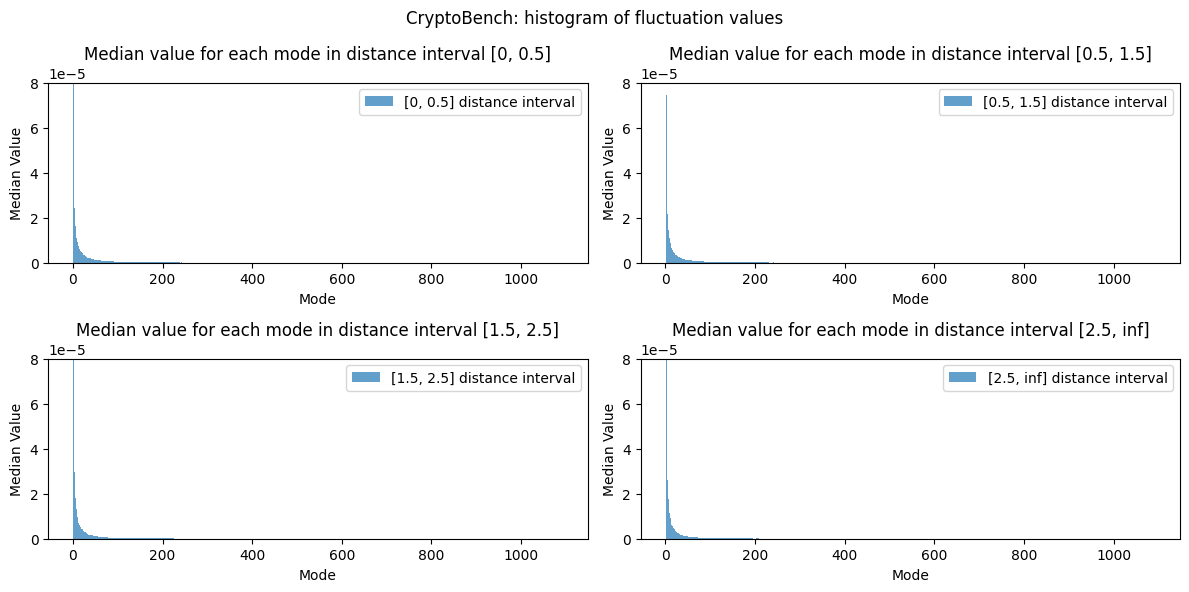

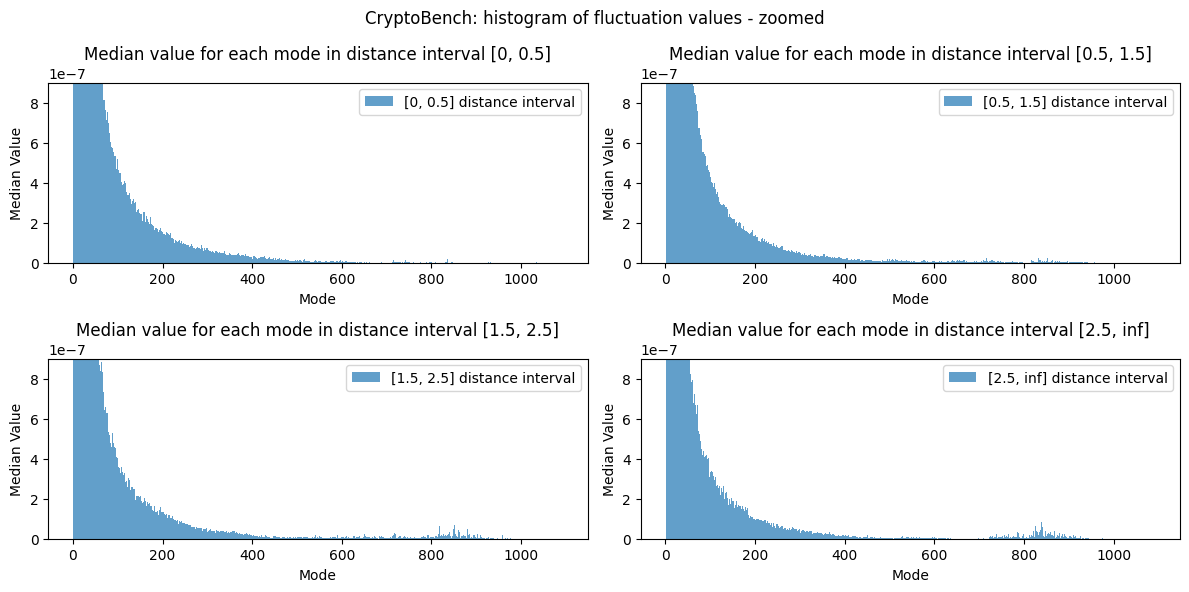

In [4]:
bins = [0, 0.5, 1.5, 2.5, np.inf]
labels = ['[0, 0.5]', '[0.5, 1.5]', '[1.5, 2.5]', '[2.5, inf]']

dataset = 'cryptobench-dataset'

binned_fluctuation_by_distance = bin_fluctuations_by_distance(dataset, bins, labels)

print_barcharts(binned_fluctuation_by_distance, title='CryptoBench: histogram of fluctuation values', lim=8e-05)
print_barcharts(binned_fluctuation_by_distance, title='CryptoBench: histogram of fluctuation values - zoomed', lim=9e-07)

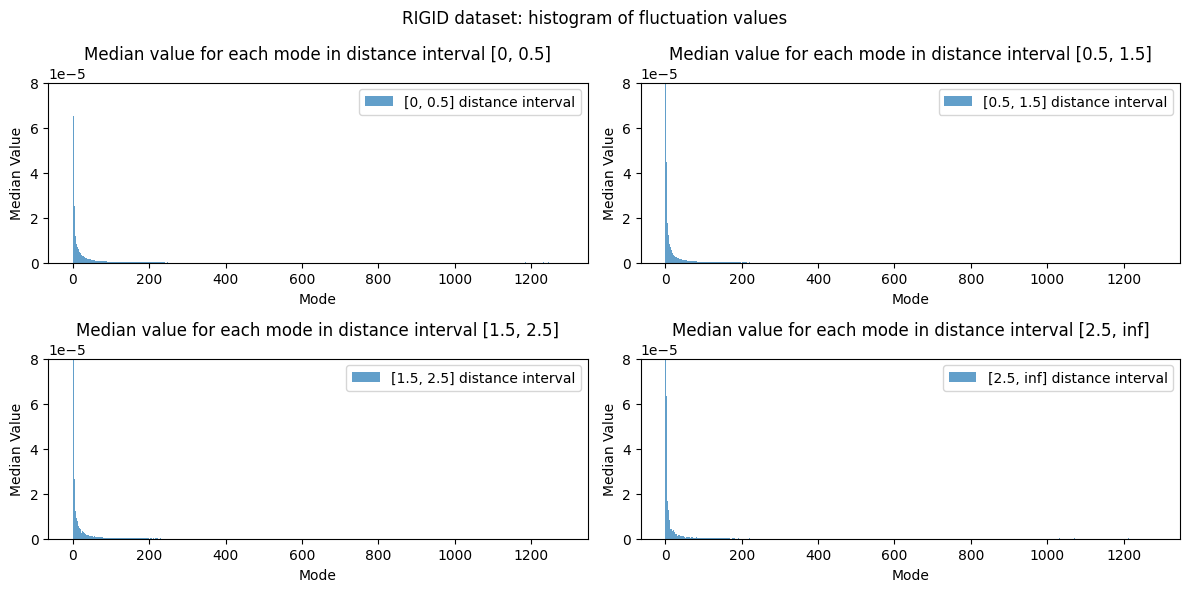

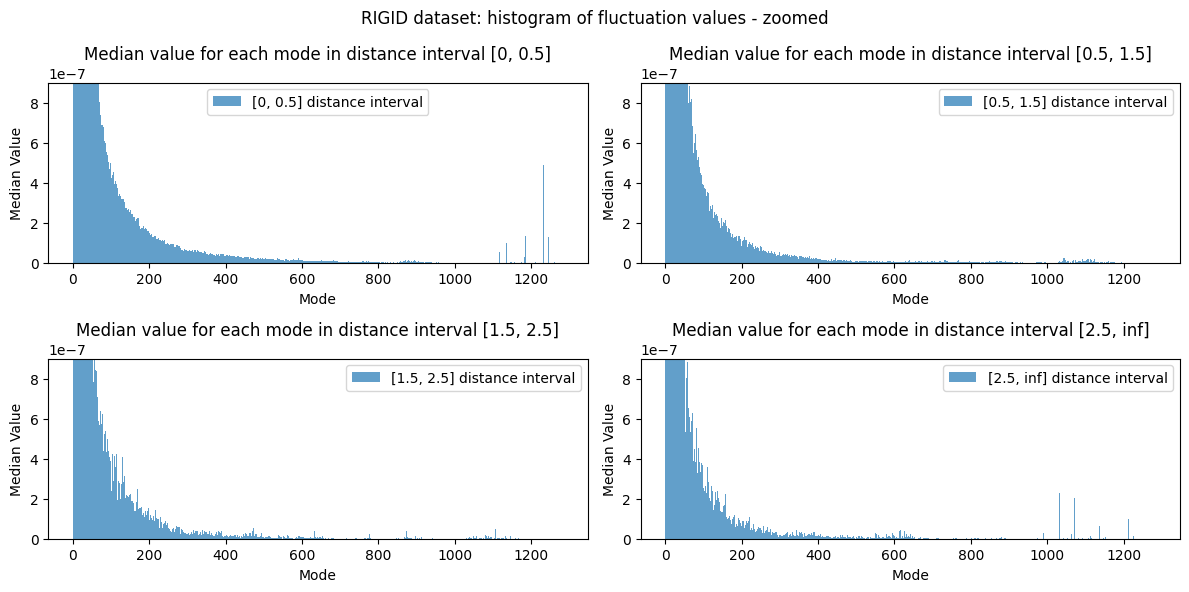

In [5]:
bins = [0, 0.5, 1.5, 2.5, np.inf]
labels = ['[0, 0.5]', '[0.5, 1.5]', '[1.5, 2.5]', '[2.5, inf]']

dataset = 'rigid-dataset'

binned_fluctuation_by_distance = bin_fluctuations_by_distance(dataset, bins, labels)

print_barcharts(binned_fluctuation_by_distance, title='RIGID dataset: histogram of fluctuation values', lim=8e-05)
print_barcharts(binned_fluctuation_by_distance, title='RIGID dataset: histogram of fluctuation values - zoomed', lim=9e-07)

Try this for the reversed mode order ...


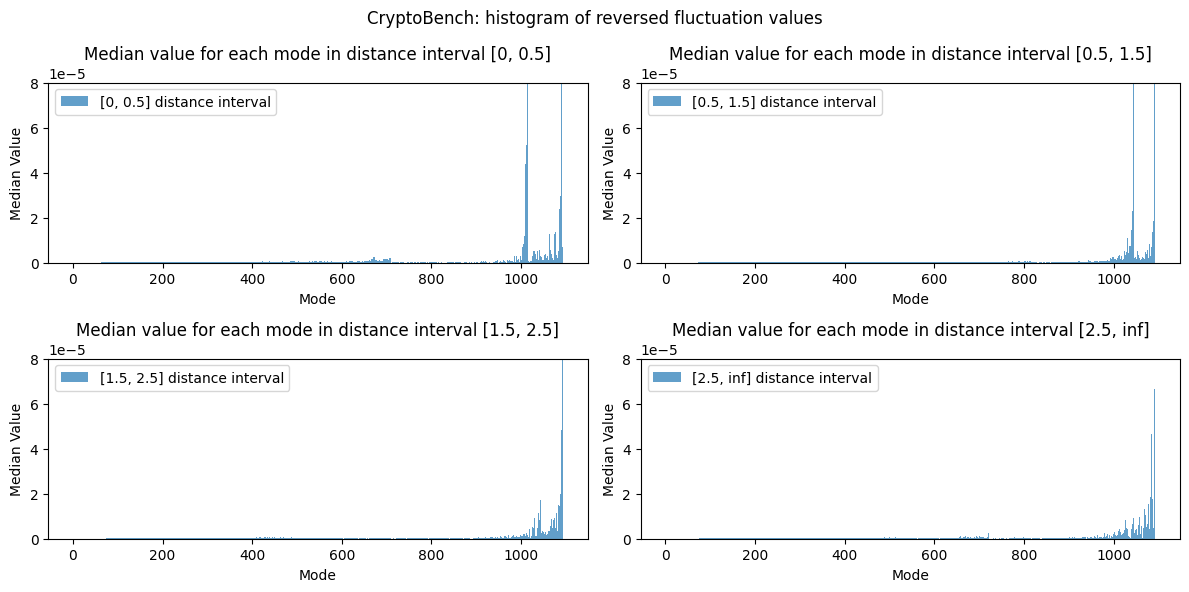

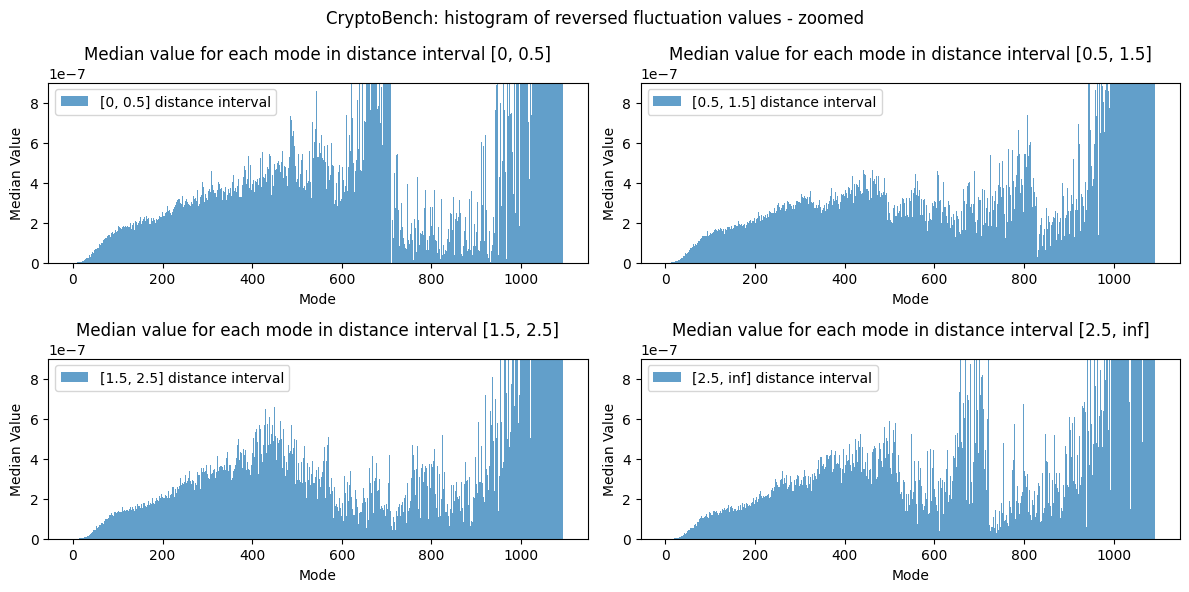

In [6]:
bins = [0, 0.5, 1.5, 2.5, np.inf]
labels = ['[0, 0.5]', '[0.5, 1.5]', '[1.5, 2.5]', '[2.5, inf]']

dataset = 'cryptobench-dataset'

binned_fluctuation_by_distance = bin_fluctuations_by_distance(dataset, bins, labels, reverse_modes=True)

print_barcharts(binned_fluctuation_by_distance, title='CryptoBench: histogram of reversed fluctuation values', lim=8e-05)
print_barcharts(binned_fluctuation_by_distance, title='CryptoBench: histogram of reversed fluctuation values - zoomed', lim=9e-07)

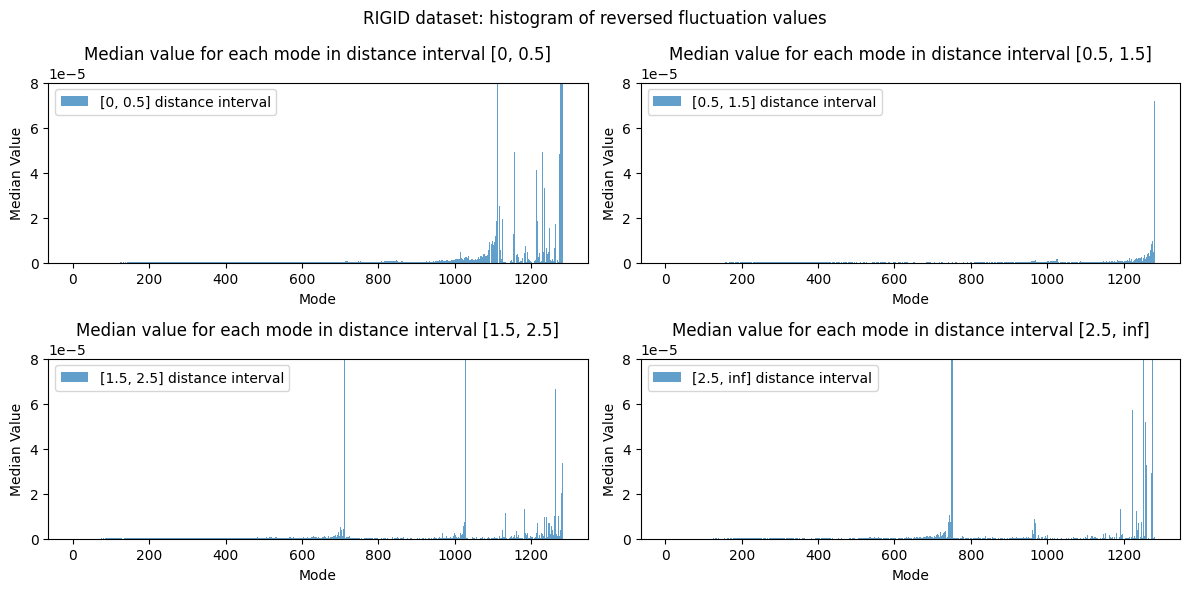

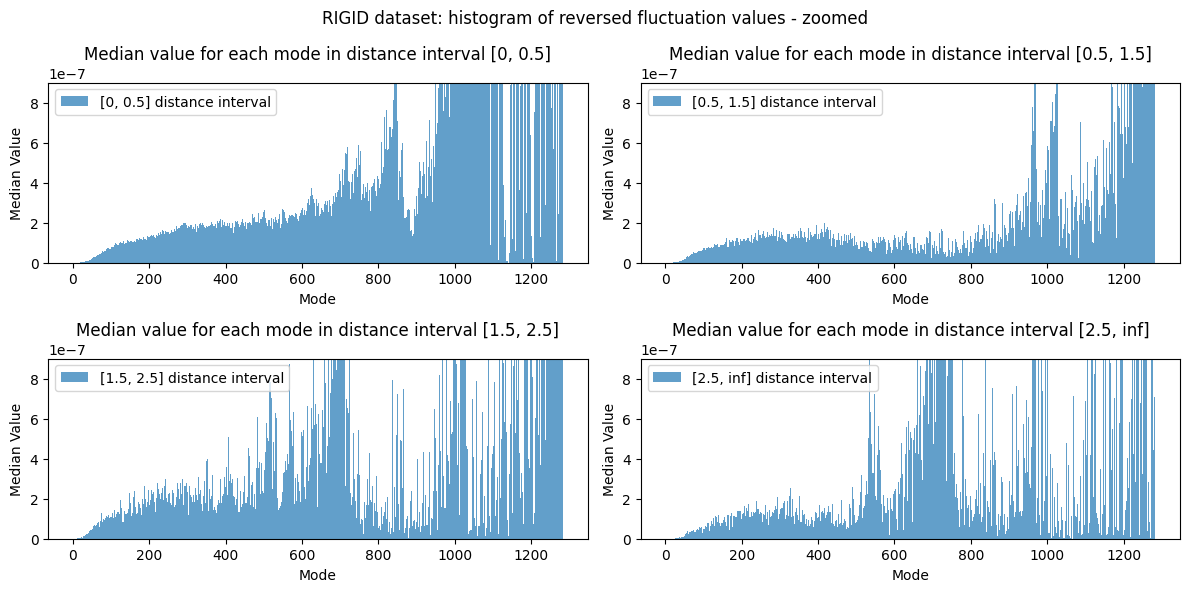

In [7]:
bins = [0, 0.5, 1.5, 2.5, np.inf]
labels = ['[0, 0.5]', '[0.5, 1.5]', '[1.5, 2.5]', '[2.5, inf]']

dataset = 'rigid-dataset'

binned_fluctuation_by_distance = bin_fluctuations_by_distance(dataset, bins, labels, reverse_modes=True)

print_barcharts(binned_fluctuation_by_distance, title='RIGID dataset: histogram of reversed fluctuation values', lim=8e-05)
print_barcharts(binned_fluctuation_by_distance, title='RIGID dataset: histogram of reversed fluctuation values - zoomed', lim=9e-07)

Compare cryptic vs. rigid


In [11]:
def load_dataset_and_pick_median(dataset, bins, labels):
    binned_fluctuation_by_distance = bin_fluctuations_by_distance(dataset, bins, labels)
    for label in binned_fluctuation_by_distance.keys():
        binned_fluctuation_by_distance[label] = [np.median(dato) for dato in binned_fluctuation_by_distance[label]]
    return binned_fluctuation_by_distance


In [33]:
bins = [0, 0.5, 1.5, 2.5, np.inf]
labels = ['[0, 0.5]', '[0.5, 1.5]', '[1.5, 2.5]', '[2.5, inf]']

binned_fluctuation_by_distance_cryptobench = load_dataset_and_pick_median('cryptobench-dataset', bins, labels)
binned_fluctuation_by_distance_rigid = load_dataset_and_pick_median('rigid-dataset', bins, labels)

print_combined_barcharts(binned_fluctuation_by_distance_cryptobench, binned_fluctuation_by_distance_rigid, title='CryptoBench vs Rigid: histogram of fluctuation values', lim=2e-06)
print_combined_barcharts(binned_fluctuation_by_distance_cryptobench, binned_fluctuation_by_distance_rigid, title='CryptoBench vs Rigid: histogram of fluctuation values - zoomed', lim=9e-07)

Mmmm the median values between cryptobench and rigid seem very similar..

Let's look into the first 200 modes:

In [34]:
from scipy.ndimage.filters import gaussian_filter1d

def combine_barcharts_over_distances(binned_fluctuation, title='', ylim=None, xlim=None):
    plt.figure(figsize=(12, 6))
    for i, (label1, data1) in enumerate(binned_fluctuation.items()):
        if xlim:
            data1 = data1[xlim[0]:]
        # Compute median values for each position
        plt.bar(range(0, len(data1)), data1, width=1.0, alpha=0.7 * (1 / (i + 1)), label=f'{label1} distance interval')
        ysmoothed = gaussian_filter1d(data1, sigma=2)
        plt.plot(range(0, len(data1)), ysmoothed, label=f'{label1} distance interval')
    plt.xlabel('Mode')
    if ylim:
        plt.ylim(0, ylim)
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    plt.ylabel('Median Value')
    plt.legend()
    plt.title(title)
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_6185/954907354.py:1: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


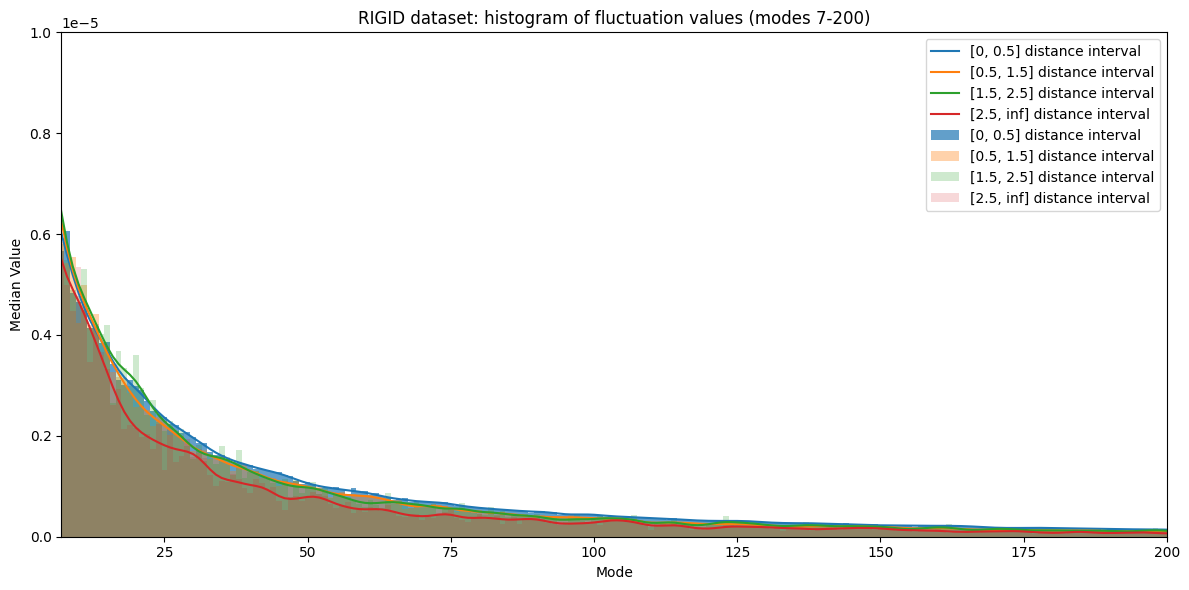

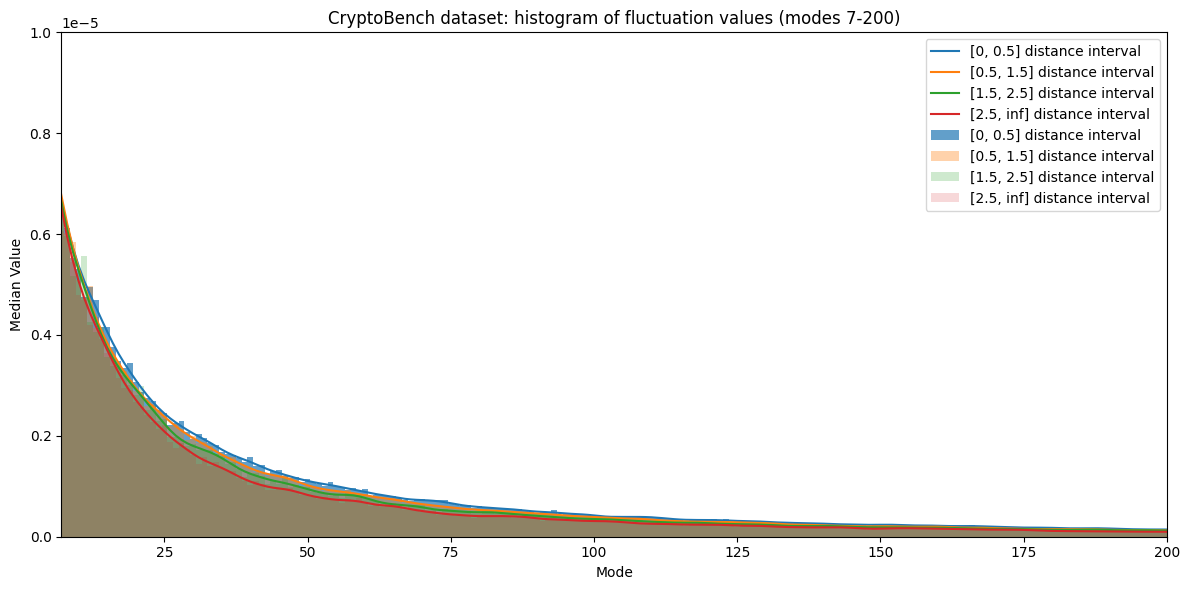

In [35]:
combine_barcharts_over_distances(binned_fluctuation_by_distance_rigid, title='RIGID dataset: histogram of fluctuation values (modes 7-200)', ylim=1e-05, xlim=(7,200))
combine_barcharts_over_distances(binned_fluctuation_by_distance_cryptobench, title='CryptoBench dataset: histogram of fluctuation values (modes 7-200)', ylim=1e-05, xlim=(7,200))

Analyze the binding sites:

In [4]:
def get_indices_path(dataset):
    return f'../../../data/features/fluctuation/{dataset}/indices'

def bin_fluctuations_by_distance_and_binding(dataset, bins, labels, reverse_modes=False):
    binned_fluctuation_binding = {label: [] for label in labels}
    binned_fluctuation_nonbinding = {label: [] for label in labels}
    for file in os.listdir(get_residue_distance_path(dataset)):
        fluctuations = np.load(f"{get_fluctuation_path(dataset)}/{file}")
        distances = np.load(f"{get_residue_distance_path(dataset)}/{file}")
        indices = np.load(f"{get_indices_path(dataset)}/{file}")

        if reverse_modes:
            fluctuations = np.flip(fluctuations, axis=0) # axis=0 means we are taking the modes (axis=1 would mean taking the residues)

        # fluctuations[0] means the first mode, fluctuation[0][1] means the first mode for the second residue, etc.

        # let's transpose it:
        fluctuations = np.transpose(fluctuations)
        # now fluctuations[0] means the fluctuations of the first residue, fluctuations[0][1] means the fluctuations of the second mode for the first residue, etc.

        # loop over the residues
        for residue_idx, residue_fluctuation in enumerate(fluctuations):
            # check which bin the distance of the residue falls into
            for i, bin in enumerate(bins):
                if bins [i] < distances[residue_idx] <= bins[i+1]:
                    if residue_idx in indices:
                        binned_fluctuation_binding[labels[i]].append(residue_fluctuation)
                    else:
                        binned_fluctuation_nonbinding[labels[i]].append(residue_fluctuation)

    # now we have the binned fluctuations dictionary
    # each key is a distance bin
    # each value is a list of residues
    # now we want to have a similar dictionary, but the values is a list of modes, so we need to transpose the entries

    binned_fluctuation_binding_transposed = {label: [] for label in labels}
    binned_fluctuation_nonbinding_transposed = {label: [] for label in labels}

    for binned_fluctuation, binned_fluctuation_transposed in zip([binned_fluctuation_binding, binned_fluctuation_nonbinding], [binned_fluctuation_binding_transposed, binned_fluctuation_nonbinding_transposed]):
        # for each distance bin
        for label, residues in binned_fluctuation.items():
            # for each residue
            for residue in residues:
                for mode_index, mode_value in enumerate(residue):
                    # if the mode is not yet in the bin, add it
                    if len(binned_fluctuation_transposed[label]) <= mode_index:
                        binned_fluctuation_transposed[label].append([])
                    # add the residue to the correct mode
                    binned_fluctuation_transposed[label][mode_index].append(mode_value)
        del binned_fluctuation

    for binned_fluctuation_transposed in [binned_fluctuation_binding_transposed, binned_fluctuation_nonbinding_transposed]:
        for label, fluctuations in binned_fluctuation_transposed.items():
            for i, fluctuation in enumerate(fluctuations):
                binned_fluctuation_transposed[label][i] = np.array(fluctuation)
    return binned_fluctuation_binding_transposed, binned_fluctuation_nonbinding_transposed

In [11]:
binding_binned_fluctuation_by_distance, nonbinding_binned_fluctuation_by_distance = bin_fluctuations_by_distance_and_binding('rigid-dataset', bins, labels)

In [12]:
binding_binned_fluctuation_by_distance['[0, 0.5]'][0].shape

(4061,)

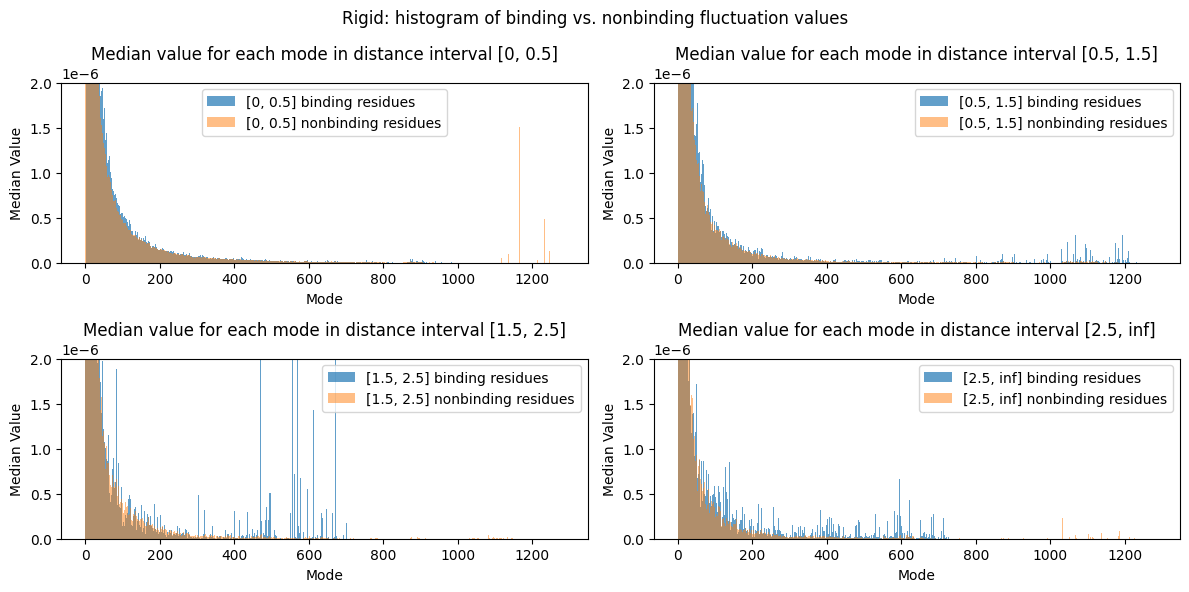

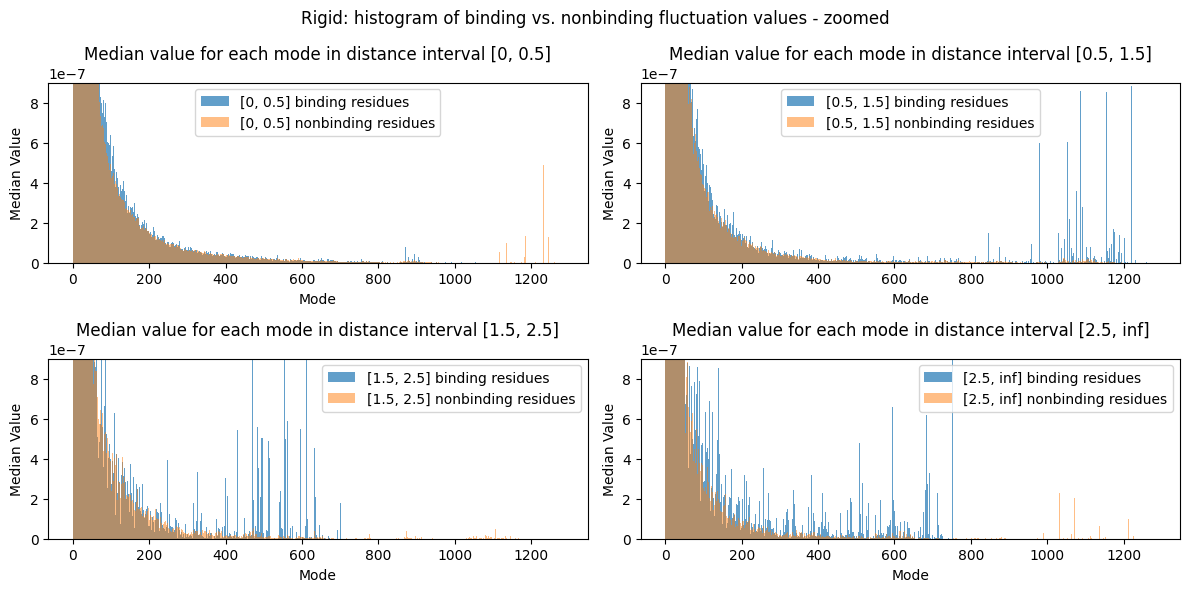

In [13]:
print_combined_barcharts(binding_binned_fluctuation_by_distance, nonbinding_binned_fluctuation_by_distance, compute_median=True, legends=['binding residues', 'nonbinding residues'],title='Rigid: histogram of binding vs. nonbinding fluctuation values', lim=2e-06)
print_combined_barcharts(binding_binned_fluctuation_by_distance, nonbinding_binned_fluctuation_by_distance, compute_median=True, legends=['binding residues', 'nonbinding residues'],title='Rigid: histogram of binding vs. nonbinding fluctuation values - zoomed', lim=9e-07)

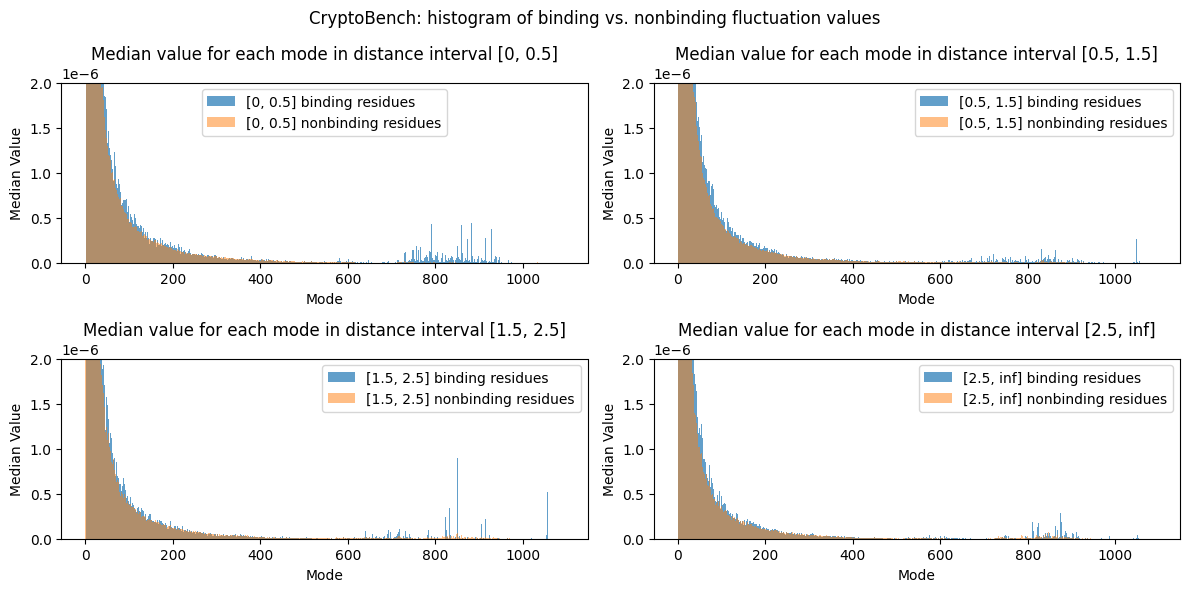

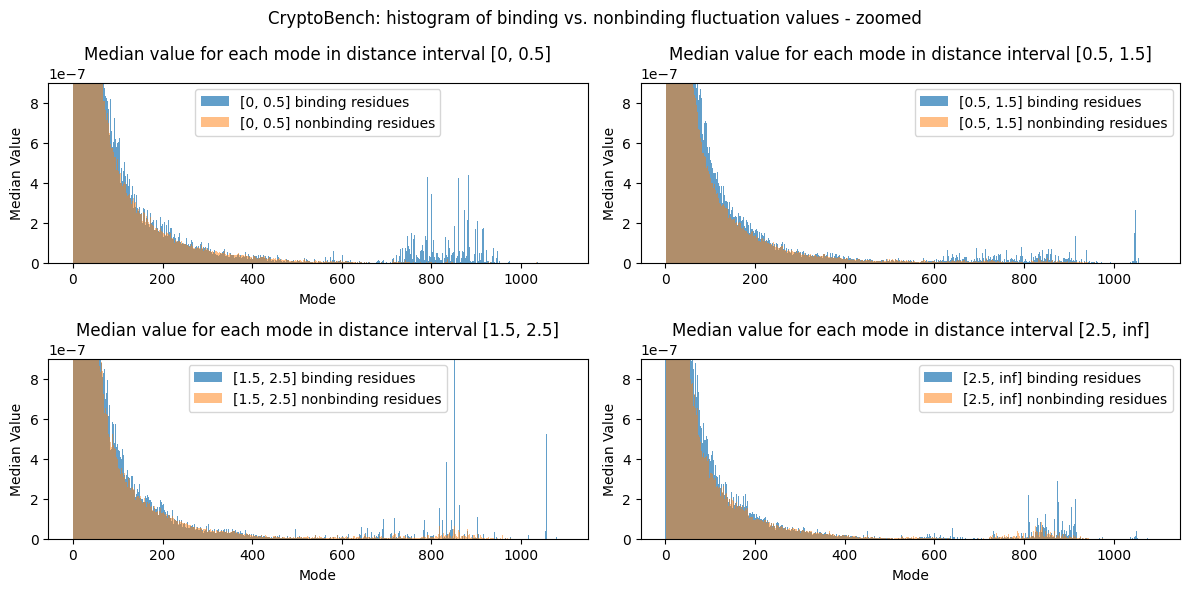

In [14]:
binding_binned_fluctuation_by_distance, nonbinding_binned_fluctuation_by_distance = bin_fluctuations_by_distance_and_binding('cryptobench-dataset', bins, labels)
print_combined_barcharts(binding_binned_fluctuation_by_distance, nonbinding_binned_fluctuation_by_distance, compute_median=True, legends=['binding residues', 'nonbinding residues'],title='CryptoBench: histogram of binding vs. nonbinding fluctuation values', lim=2e-06)
print_combined_barcharts(binding_binned_fluctuation_by_distance, nonbinding_binned_fluctuation_by_distance, compute_median=True, legends=['binding residues', 'nonbinding residues'],title='CryptoBench: histogram of binding vs. nonbinding fluctuation values - zoomed', lim=9e-07)

# Try larger bins
something like [0-2], [2-4], [4-8], [8-inf].

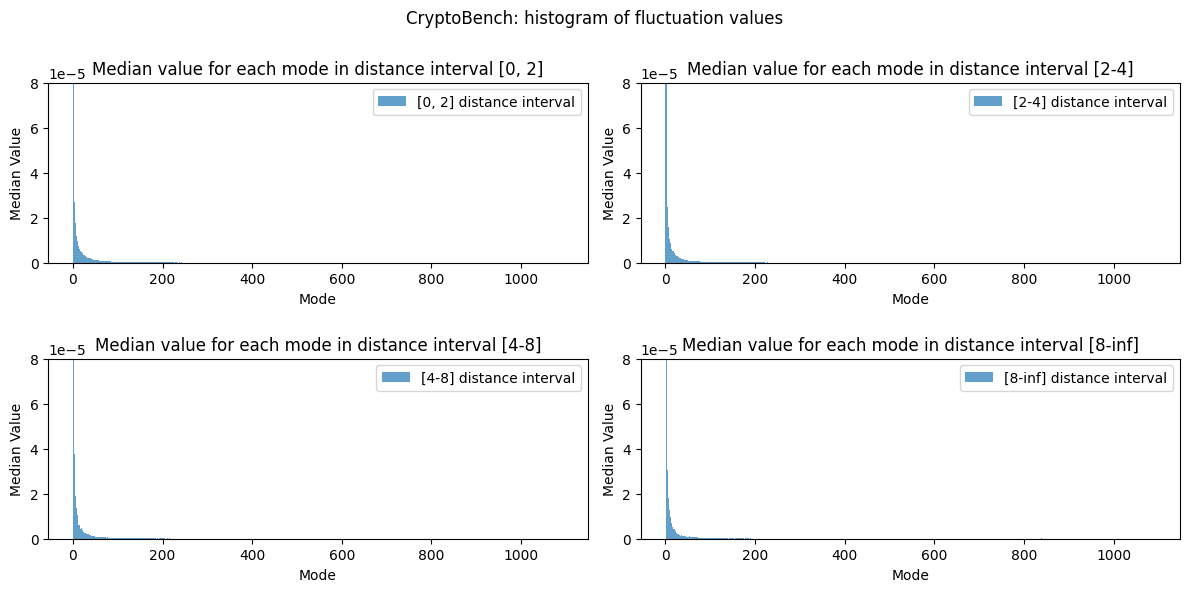

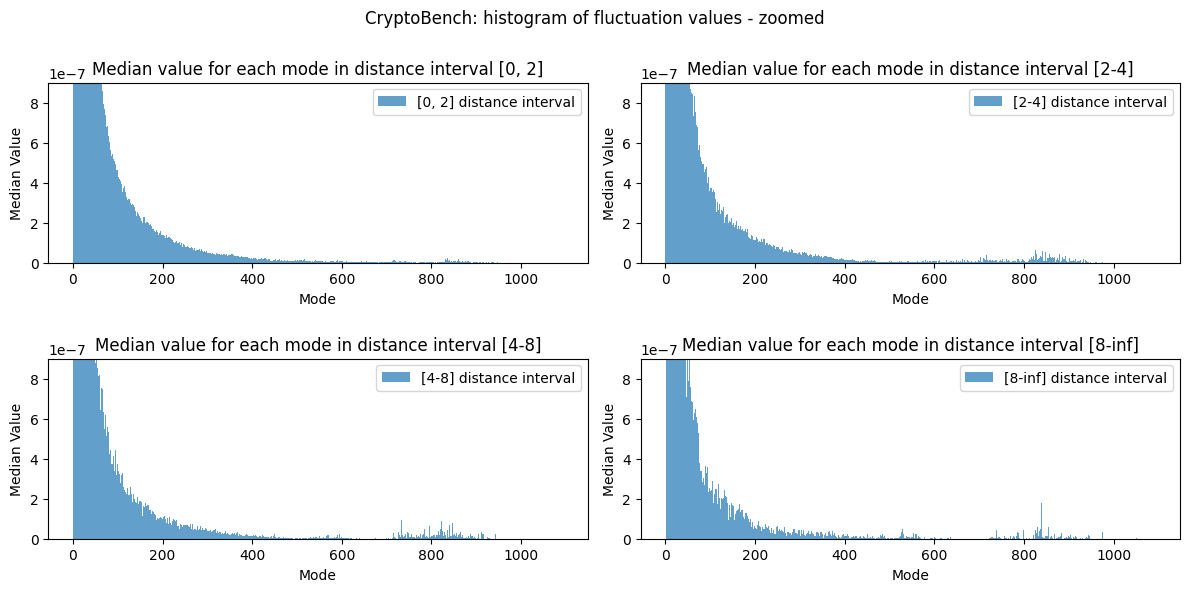

In [4]:
bins = [0, 2, 4, 8, np.inf]
labels = ['[0, 2]', '[2-4]', '[4-8]', '[8-inf]']

dataset = 'cryptobench-dataset'

binned_fluctuation_by_distance = bin_fluctuations_by_distance(dataset, bins, labels)

print_barcharts(binned_fluctuation_by_distance, title='CryptoBench: histogram of fluctuation values', lim=8e-05)
print_barcharts(binned_fluctuation_by_distance, title='CryptoBench: histogram of fluctuation values - zoomed', lim=9e-07)

examine larger bins ..

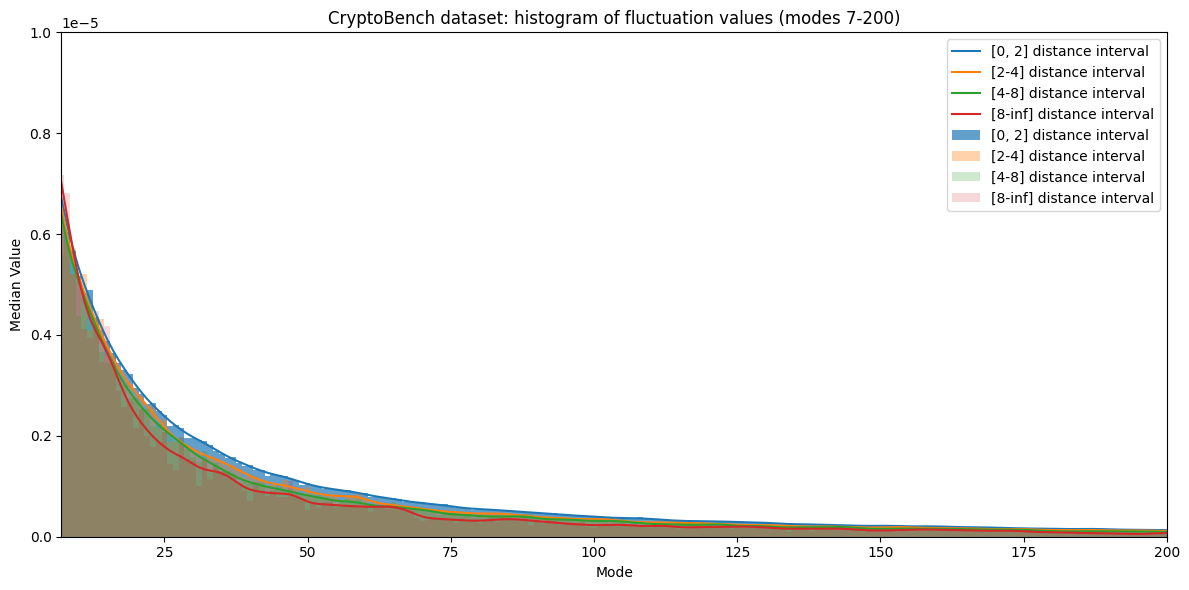

In [36]:
bins = [0, 2, 4, 8, np.inf]
labels = ['[0, 2]', '[2-4]', '[4-8]', '[8-inf]']
dataset = 'cryptobench-dataset'

binned_fluctuation_by_distance_cryptobench = load_dataset_and_pick_median(dataset, bins, labels)
combine_barcharts_over_distances(binned_fluctuation_by_distance_cryptobench, title='CryptoBench dataset: histogram of fluctuation values (modes 7-200)', ylim=1e-05, xlim=(7,200))

/tmp/ipykernel_6185/1853282752.py:1: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


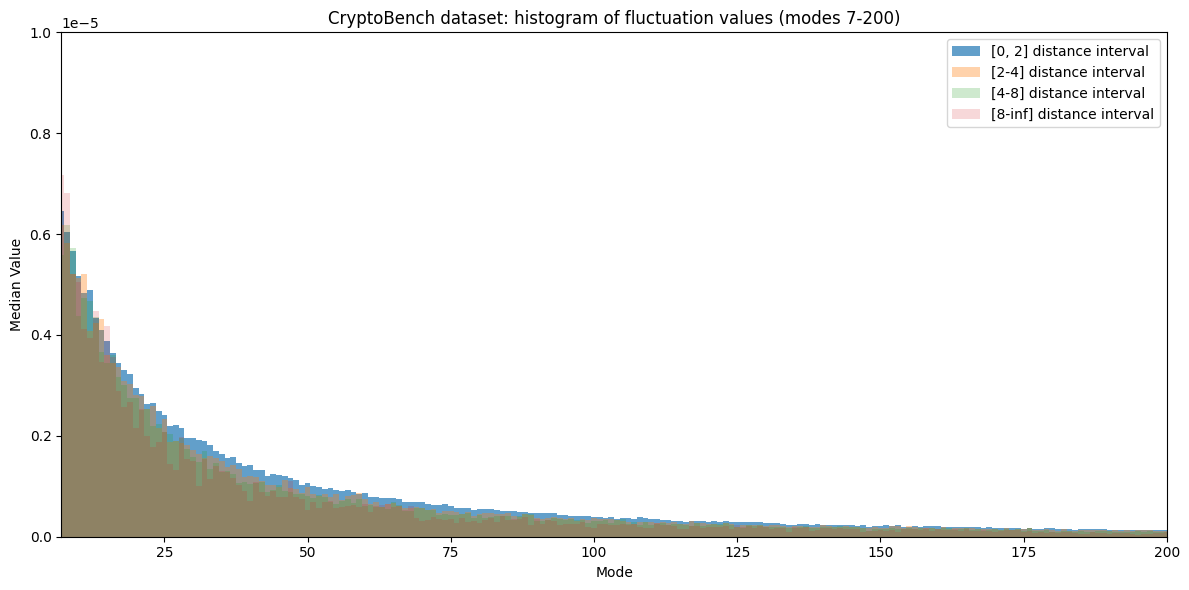

In [37]:
from scipy.ndimage.filters import gaussian_filter1d

def combine_barcharts_over_distances(binned_fluctuation, title='', ylim=None, xlim=None):
    plt.figure(figsize=(12, 6))
    for i, (label1, data1) in enumerate(binned_fluctuation.items()):
        if xlim:
            data1 = data1[xlim[0]:]
        # Compute median values for each position
        plt.bar(range(0, len(data1)), data1, width=1.0, alpha=0.7 * (1 / (i + 1)), label=f'{label1} distance interval')
        # ysmoothed = gaussian_filter1d(data1, sigma=2)
        # plt.plot(range(0, len(data1)), ysmoothed, label=f'{label1} distance interval')
    plt.xlabel('Mode')
    if ylim:
        plt.ylim(0, ylim)
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    plt.ylabel('Median Value')
    plt.legend()
    plt.title(title)
    plt.tight_layout()
    plt.show()
combine_barcharts_over_distances(binned_fluctuation_by_distance_cryptobench, title='CryptoBench dataset: histogram of fluctuation values (modes 7-200)', ylim=1e-05, xlim=(7,200))

In [8]:
bins = [0, 2, 4, 8, np.inf]
labels = ['[0-2]', '[2-4]', '[4-8]', '[8-inf]']
dataset = 'cryptobench-dataset'

def load_dataset(dataset, bins, labels):
    return bin_fluctuations_by_distance(dataset, bins, labels)

loaded_cryptobench_dataset = load_dataset(dataset, bins, labels)
dataset = 'rigid-dataset'
loaded_rigid_dataset = load_dataset(dataset, bins, labels)


In [ ]:
from matplotlib.lines import Line2D

def boxplot2(binned_fluctuation_by_distance1, binned_fluctuation_by_distance2, xlim=(7,20), ylim=None, title='', labels=['', '']):
    colors = ['pink', 'lightblue']
    plt.figure(figsize=(12, 6))
    plt.suptitle(title)
    for bin, figure_index in zip(binned_fluctuation_by_distance1.keys(), [221,222,223,224]):
        plt.subplot(figure_index)
        x = np.array(list(range(xlim[0], xlim[1])))
        
        boxplot1 = plt.boxplot(binned_fluctuation_by_distance1[bin][xlim[0]:xlim[1]],0,'',positions=x-0.2,widths=0.2, patch_artist=True)
        boxplot2 = plt.boxplot(binned_fluctuation_by_distance2[bin][xlim[0]:xlim[1]],0,'',positions=x+0.2,widths=0.2, patch_artist=True)
        
        # fill with color:
        for bplot, color in zip((boxplot1, boxplot2), colors):
            for patch in bplot['boxes']:
                patch.set_facecolor(color)
        
        custom_lines = [Line2D([0], [0], color=colors[0], lw=4),
                        Line2D([0], [0], color=colors[1], lw=4)]

        plt.legend(custom_lines, labels)

        plt.title(f'Fluctuation value for each mode in distance interval {bin}')
        plt.xlabel('Mode')
        plt.xticks(x, x)

        if ylim:
            plt.ylim(0, ylim)
        plt.ylabel('Fluctuation value')

    plt.tight_layout()
    plt.show()

def boxplot(binned_fluctuation_by_distance1, binned_fluctuation_by_distance2, xlim=(7,20), ylim=None, title='', labels=['', '']):
    colors = ['pink', 'lightblue']
    for label in binned_fluctuation_by_distance1.keys():
        x = np.array(list(range(xlim[0], xlim[1])))

        boxplot1 = plt.boxplot(binned_fluctuation_by_distance1[label][xlim[0]:xlim[1]],0,'',positions=x-0.2,widths=0.2, patch_artist=True)
        boxplot2 = plt.boxplot(binned_fluctuation_by_distance2[label][xlim[0]:xlim[1]],0,'',positions=x+0.2,widths=0.2, patch_artist=True)
        
        # fill with color:
        for bplot, color in zip((boxplot1, boxplot2), colors):
            for patch in bplot['boxes']:
                patch.set_facecolor(color)
        
        custom_lines = [Line2D([0], [0], color=colors[0], lw=4),
                        Line2D([0], [0], color=colors[1], lw=4)]

        plt.legend(custom_lines, labels)
        break
    plt.xlabel('Mode')
    print(x)
    plt.xticks(x, x)
    if ylim:
        plt.ylim(0, ylim)
    # if xlim:
    #     plt.xlim(xlim[0], xlim[1])
    plt.ylabel('Fluctuation value')
    plt.title(title)
    plt.tight_layout()
    plt.show()



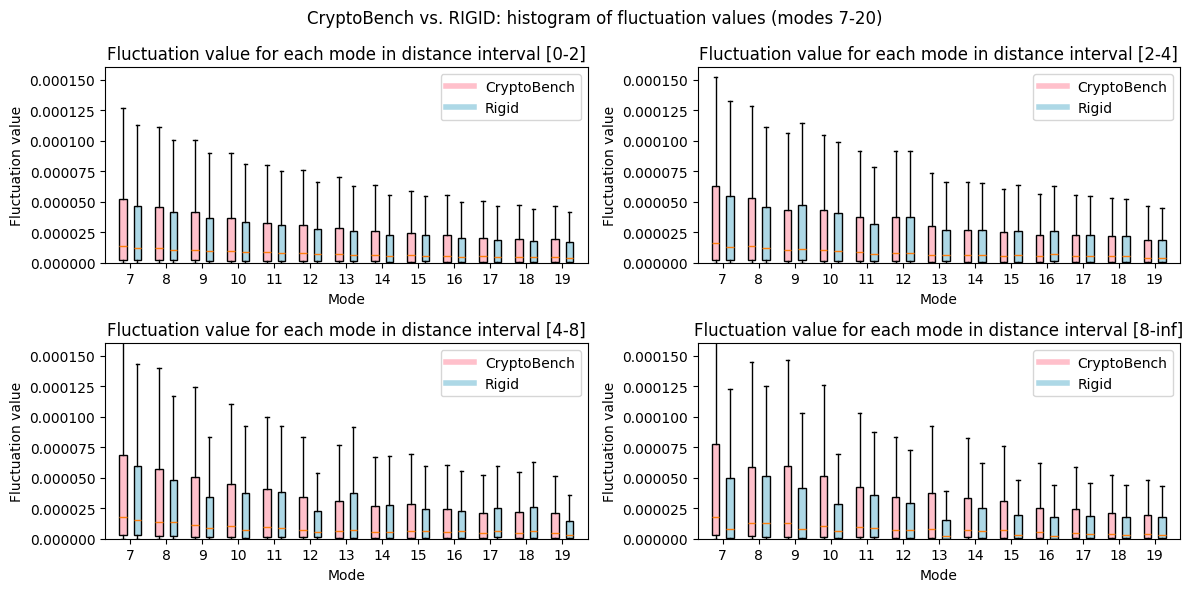

In [9]:
boxplot2(loaded_cryptobench_dataset, loaded_rigid_dataset, title='CryptoBench vs. RIGID: histogram of fluctuation values (modes 7-20)', ylim=1.6e-04, xlim=(7,20), labels=['CryptoBench', 'Rigid'])

There is quite a lot of instances in the [8-inf] bin for the RIGID dataset. However, large majority of them is not binding (41 out of 3977 is binding - see below) ...

In [59]:
print(loaded_rigid_dataset.keys())
print(loaded_rigid_dataset['[8-inf]'][0].shape)
print(loaded_cryptobench_dataset['[8-inf]'][0].shape)
print(loaded_rigid_dataset['[0-2]'][0].shape)

dict_keys(['[0-2]', '[2-4]', '[4-8]', '[8-inf]'])
(3977,)
(9483,)
(170928,)


Try to break down by binding vs. non-binding ...

In [63]:
binding_binned_fluctuation_by_distance_cryptobench, nonbinding_binned_fluctuation_by_distance_cryptobench = bin_fluctuations_by_distance_and_binding('cryptobench-dataset', bins, labels)

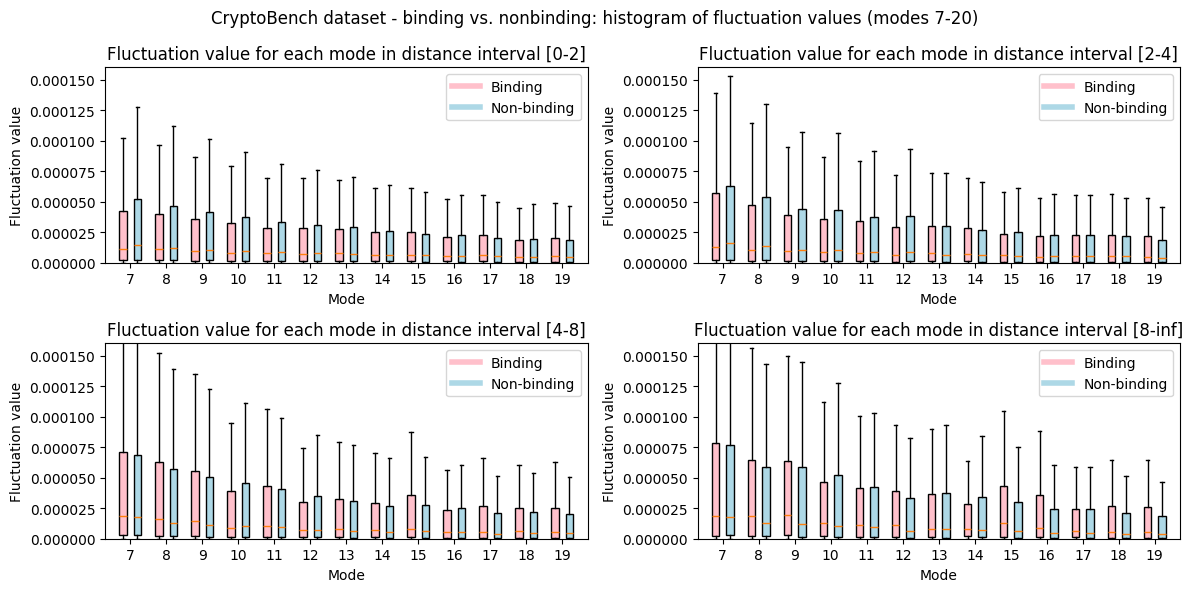

In [1]:
boxplot2(binding_binned_fluctuation_by_distance_cryptobench, nonbinding_binned_fluctuation_by_distance_cryptobench, 
         title='CryptoBench dataset - binding vs. nonbinding: histogram of fluctuation values (modes 7-20)', ylim=1.6e-04, xlim=(7,20), labels=['Binding', 'Non-binding'])

In [74]:
for label in binding_binned_fluctuation_by_distance_cryptobench.keys():
    print(label)
    print(binding_binned_fluctuation_by_distance_cryptobench[label][0].shape[0], ' binding vs. ', nonbinding_binned_fluctuation_by_distance_cryptobench[label][0].shape[0], ' nonbinding')


[0-2]
7737  binding vs.  159616  nonbinding
[2-4]
2986  binding vs.  34037  nonbinding
[4-8]
1747  binding vs.  14948  nonbinding
[8-inf]
628  binding vs.  8855  nonbinding


In [66]:
binding_binned_fluctuation_by_distance_rigid, nonbinding_binned_fluctuation_by_distance_rigid = bin_fluctuations_by_distance_and_binding('rigid-dataset', bins, labels)

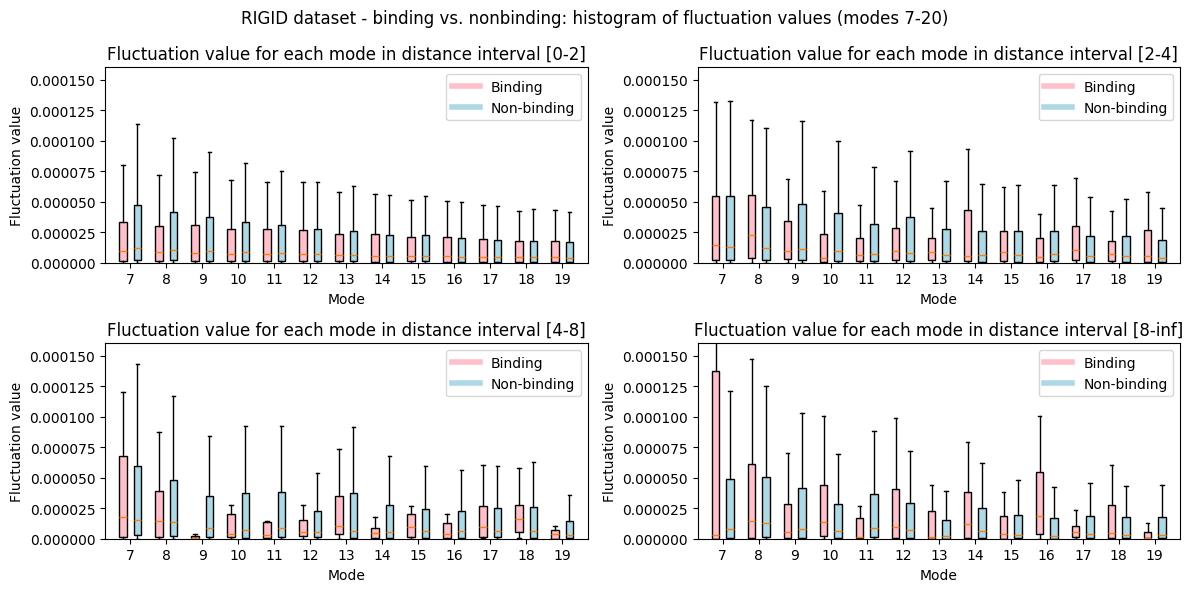

In [73]:
boxplot2(binding_binned_fluctuation_by_distance_rigid, nonbinding_binned_fluctuation_by_distance_rigid, 
         title='RIGID dataset - binding vs. nonbinding: histogram of fluctuation values (modes 7-20)', ylim=1.6e-04, xlim=(7,20), labels=['Binding', 'Non-binding'])

This graph cannot be taken too seriously as there is too little data for the [2-4], [4-8] and [8-inf] intervals - see below

In [69]:
for label in binding_binned_fluctuation_by_distance_rigid.keys():
    print(label)
    print(binding_binned_fluctuation_by_distance_rigid[label][0].shape[0], ' binding vs. ', nonbinding_binned_fluctuation_by_distance_rigid[label][0].shape[0], ' nonbinding')


[0-2]
5133  binding vs.  165795  nonbinding
[2-4]
107  binding vs.  4967  nonbinding
[4-8]
23  binding vs.  2325  nonbinding
[8-inf]
41  binding vs.  3936  nonbinding


IDEA: How often does binding move more than 8A compared to non-binding?

In [ ]:
binding_binned_fluctuation_by_distance_cryptobench, nonbinding_binned_fluctuation_by_distance_cryptobench = bin_fluctuations_by_distance_and_binding('cryptobench-dataset', bins, labels)
boxplot2(binding_binned_fluctuation_by_distance_cryptobench, nonbinding_binned_fluctuation_by_distance_cryptobench, 
         title='CryptoBench dataset - binding vs. nonbinding: histogram of fluctuation values (modes 7-20)', ylim=1.6e-04, xlim=(7,20), labels=['Binding', 'Non-binding'])



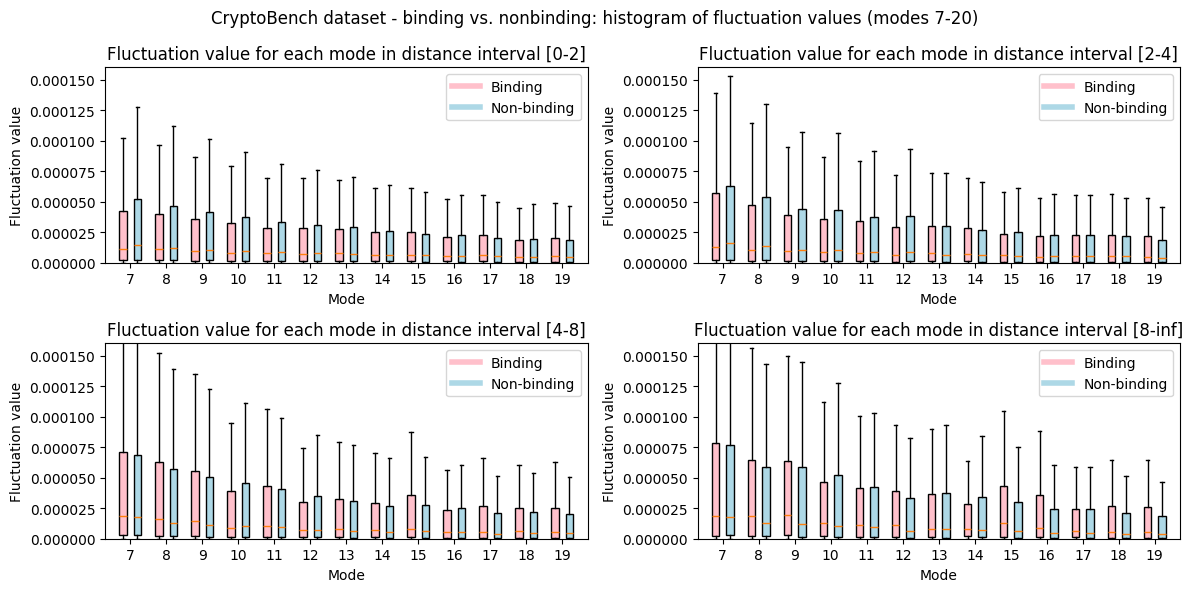

7th mode - number of samples for the [8-inf] bin; Binding: 628 vs. Non-binding: 8855 -> 628 / 9483 = 0.06622376884952019
Means that only 6.62% are binding samples (which correlates with the ratio of CBS vs. Non-CBS residues from the whole dataset - it is 5.68%)


In [27]:
boxplot2(binding_binned_fluctuation_by_distance_cryptobench, nonbinding_binned_fluctuation_by_distance_cryptobench, 
         title='CryptoBench dataset - binding vs. nonbinding: histogram of fluctuation values (modes 7-20)', ylim=1.6e-04, xlim=(7,20), labels=['Binding', 'Non-binding'])
def compute_ratio_of_whole_dataset(binding, nonbinding):
    binding_samples = 0
    nonbinding_samples = 0  
    for k, v in binding.items():
        binding_samples += v[0].shape[0]
    for k, v in nonbinding.items():
        nonbinding_samples += v[0].shape[0]
    return binding_samples / (binding_samples + nonbinding_samples)
print(f"7th mode - number of samples for the [8-inf] bin; Binding: {len(binding_binned_fluctuation_by_distance_cryptobench['[8-inf]'][0])} vs. Non-binding: {len(nonbinding_binned_fluctuation_by_distance_cryptobench['[8-inf]'][0])} -> {len(binding_binned_fluctuation_by_distance_cryptobench['[8-inf]'][0])} / {len(binding_binned_fluctuation_by_distance_cryptobench['[8-inf]'][0]) + len(nonbinding_binned_fluctuation_by_distance_cryptobench['[8-inf]'][0])} = {len(binding_binned_fluctuation_by_distance_cryptobench['[8-inf]'][0]) / (len(binding_binned_fluctuation_by_distance_cryptobench['[8-inf]'][0]) + len(nonbinding_binned_fluctuation_by_distance_cryptobench['[8-inf]'][0]))}")
print(f"Means that only {len(binding_binned_fluctuation_by_distance_cryptobench['[8-inf]'][0]) / (len(binding_binned_fluctuation_by_distance_cryptobench['[8-inf]'][0]) + len(nonbinding_binned_fluctuation_by_distance_cryptobench['[8-inf]'][0])) * 100:.2f}% are binding samples (which correlates with the ratio of CBS vs. Non-CBS residues from the whole dataset - it is {compute_ratio_of_whole_dataset(binding_binned_fluctuation_by_distance_cryptobench, nonbinding_binned_fluctuation_by_distance_cryptobench) * 100:.2f}%)")


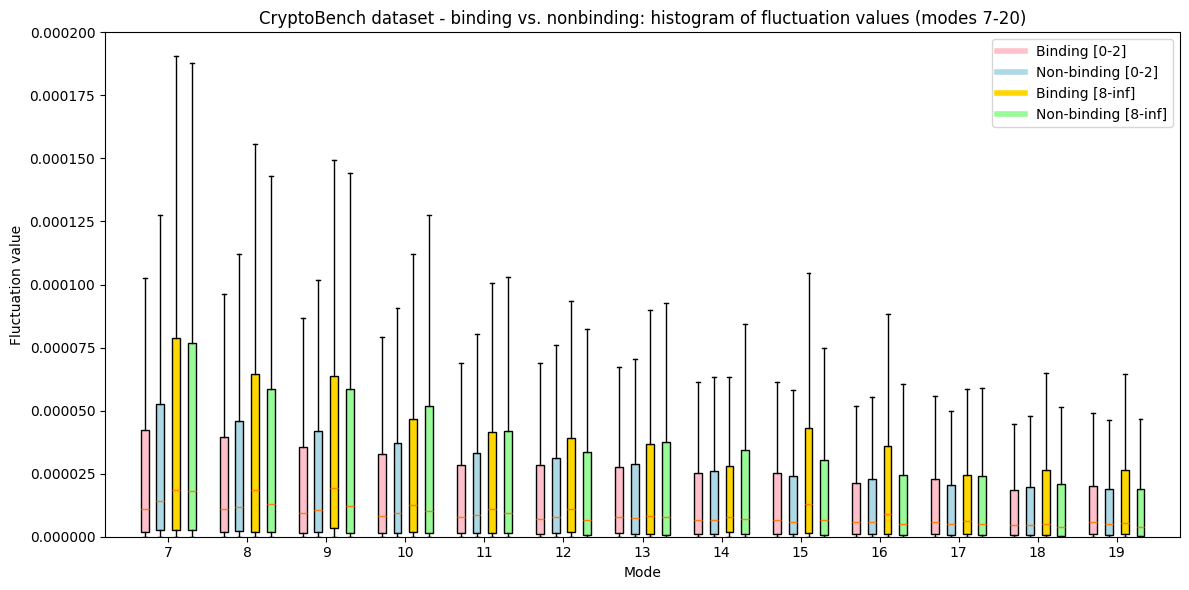

In [ ]:
def boxplot3(binned_fluctuation_by_distance1, binned_fluctuation_by_distance2, binned_fluctuation_by_distance3, binned_fluctuation_by_distance4, xlim=(7,20), ylim=None, title='', labels=['', '', '', '']):
    plt.figure(figsize=(12, 6))
    colors = ['pink', 'lightblue', 'gold', 'palegreen']
    x = np.array(list(range(xlim[0], xlim[1])))

    boxplot1 = plt.boxplot(binned_fluctuation_by_distance1[xlim[0]:xlim[1]],0,'',positions=x-0.3,widths=0.1, patch_artist=True)
    boxplot2 = plt.boxplot(binned_fluctuation_by_distance2[xlim[0]:xlim[1]],0,'',positions=x-0.1,widths=0.1, patch_artist=True)
    boxplot3 = plt.boxplot(binned_fluctuation_by_distance3[xlim[0]:xlim[1]],0,'',positions=x+0.1,widths=0.1, patch_artist=True)
    boxplot4 = plt.boxplot(binned_fluctuation_by_distance4[xlim[0]:xlim[1]],0,'',positions=x+0.3,widths=0.1, patch_artist=True)
    
    # fill with color:
    for bplot, color in zip((boxplot1, boxplot2, boxplot3, boxplot4), colors):
        for patch in bplot['boxes']:
            patch.set_facecolor(color)
    
    custom_lines = [Line2D([0], [0], color=colors[0], lw=4),
                    Line2D([0], [0], color=colors[1], lw=4),
                    Line2D([0], [0], color=colors[2], lw=4),
                    Line2D([0], [0], color=colors[3], lw=4)]

    plt.legend(custom_lines, labels)
    
    plt.xlabel('Mode')

    plt.xticks(x, x)
    if ylim:
        plt.ylim(0, ylim)
    plt.ylabel('Fluctuation value')
    plt.title(title)
    plt.tight_layout()
    plt.show()


boxplot3(binding_binned_fluctuation_by_distance_cryptobench['[0-2]'], nonbinding_binned_fluctuation_by_distance_cryptobench['[0-2]'],
         binding_binned_fluctuation_by_distance_cryptobench['[8-inf]'], nonbinding_binned_fluctuation_by_distance_cryptobench['[8-inf]'], 
         title='CryptoBench dataset - binding vs. nonbinding: histogram of fluctuation values (modes 7-20)', ylim=2e-04, xlim=(7,20), labels=['Binding [0-2]', 'Non-binding [0-2]', 'Binding [8-inf]', 'Non-binding [8-inf]'])